In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline  

import os 
import random

In [2]:
filename = os.path.join("datasets", "names.txt")

In [3]:
# Read in all the words 
words = open(filename, 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [25]:
# build the vocabulary of characters and mappings to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [273]:
block_size = 3 # context length: how many characters do we take to predict the next one ?

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one ?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '------->' ,itos[ix])
            context = context[1:] + [ix] # crop and append 


    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y 


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [211]:
# MLP revisited 
n_embd = 10 # the dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer of the MLP 
block_size = 3

g = torch.Generator().manual_seed(2147483647)   # for reproducibility 
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  * (5/3)/((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g)    * 0
parameters  = [C, W1, b1, W2, b2]

# Bash Normalization 
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))   # Will be updated during training 
bnstd_running = torch.zeros((1, n_hidden))   # Will be updated during training 


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters ))  # Number of parameters in total 
for p in parameters:
    p.requires_grad = True  

12297


torch.Size([1000, 200])
tensor(-0.0026) tensor(0.9971)
tensor(-0.0025) tensor(0.9991)


(array([2.03141721e-05, 0.00000000e+00, 0.00000000e+00, 4.06283442e-05,
        1.62513377e-04, 1.21885032e-04, 1.01570860e-04, 2.64084237e-04,
        4.87540130e-04, 8.32881055e-04, 2.13298807e-03, 3.51435177e-03,
        5.87079573e-03, 1.06852545e-02, 1.70639045e-02, 2.97196338e-02,
        4.75554768e-02, 7.22575101e-02, 1.09208989e-01, 1.58288029e-01,
        2.15330224e-01, 2.81432540e-01, 3.44304903e-01, 3.99925106e-01,
        4.24688082e-01, 4.15709217e-01, 3.75040245e-01, 3.21776486e-01,
        2.52931757e-01, 1.91562643e-01, 1.34418877e-01, 9.22466554e-02,
        5.92361258e-02, 3.79265593e-02, 2.29143861e-02, 1.49918590e-02,
        8.53195227e-03, 4.95665799e-03, 2.90492661e-03, 1.84858966e-03,
        9.34451916e-04, 3.65655097e-04, 1.62513377e-04, 1.21885032e-04,
        1.01570860e-04, 8.12566883e-05, 2.03141721e-05, 0.00000000e+00,
        2.03141721e-05, 2.03141721e-05]),
 array([-6.10335732, -5.85722373, -5.61109015, -5.36495656, -5.11882298,
        -4.87268939, 

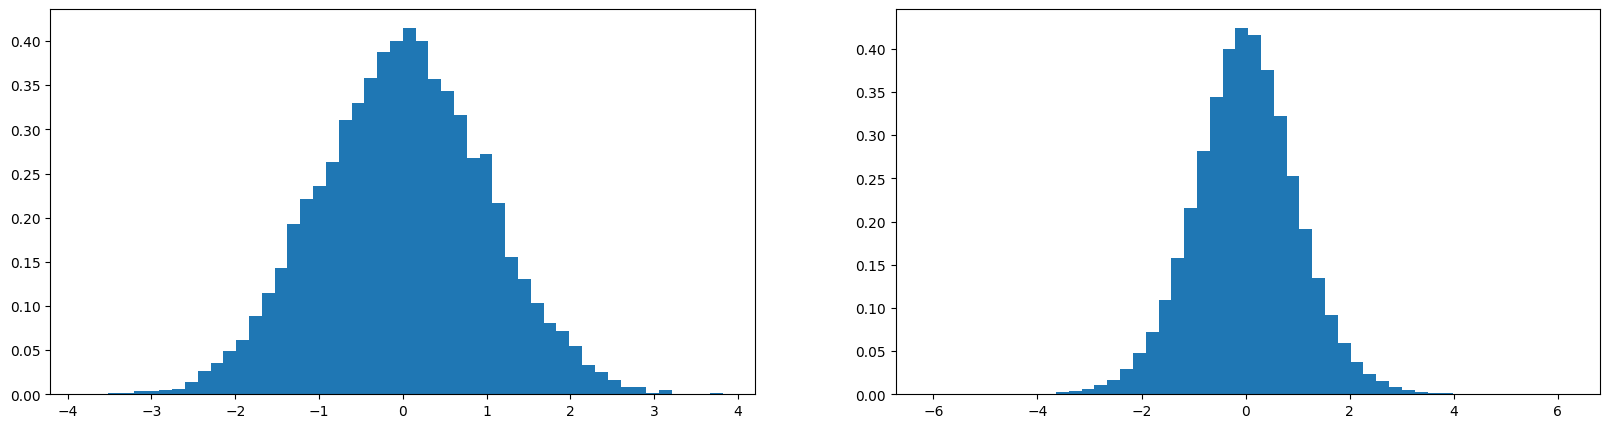

In [212]:
# Illustration code for learning how to set scale 
x = torch.randn(1000, 10)
w = torch.randn(10, 200)  / 10 ** 0.5
y = x @ w 
print(y.shape)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122) 
plt.hist(y.view(-1).tolist(), 50, density=True)

In [214]:
# Same optimization as last time 
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    

    # forward pass 
    emb = C[Xb] # embed the characters into vectors 
    embcat = emb.view(emb.shape[0], -1 )  # Concatenate the vectors 
    # Linear Layer 
    hreact = embcat @ W1  # + b1  # Hidden layer pre-activation 

    # BatchNorm Layer 
    # ------------------------------------------------------------------------
    bnmean1 = hreact.mean(0, keepdim=True)
    bnstd1 = hreact.std(0, keepdim=True)
    hreact = bngain *  (hreact - bnmean1) / bnstd1 + bnbias # Normailization  
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean1 
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd1
    # ------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh( hreact )  # Hidden layer 
    logits = h @ W2 + b2  # Output layer 
    loss = F.cross_entropy(logits, Yb)  # loss function 
    # print(loss.item())

    # backward pass
    for p in parameters: 
        p.grad = None 
    loss.backward()
    
    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay 
    for p in parameters:
        if p.grad is not None:  # Only update parameters with gradients
            p.data += -lr * p.grad

    
    # track stats 
    if i % 10000 == 0:  # print every once in a while 
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break
print(loss.item())

      0/ 200000:3.2805
  10000/ 200000:1.9454
  20000/ 200000:2.1360
  30000/ 200000:2.4764
  40000/ 200000:2.0615
  50000/ 200000:1.9833
  60000/ 200000:1.8989
  70000/ 200000:2.2840
  80000/ 200000:2.0545
  90000/ 200000:1.7882
 100000/ 200000:2.1767
 110000/ 200000:2.1106
 120000/ 200000:2.1033
 130000/ 200000:2.0922
 140000/ 200000:1.8261
 150000/ 200000:1.7593
 160000/ 200000:2.0791
 170000/ 200000:1.8723
 180000/ 200000:1.7775
 190000/ 200000:2.1840
2.232966899871826


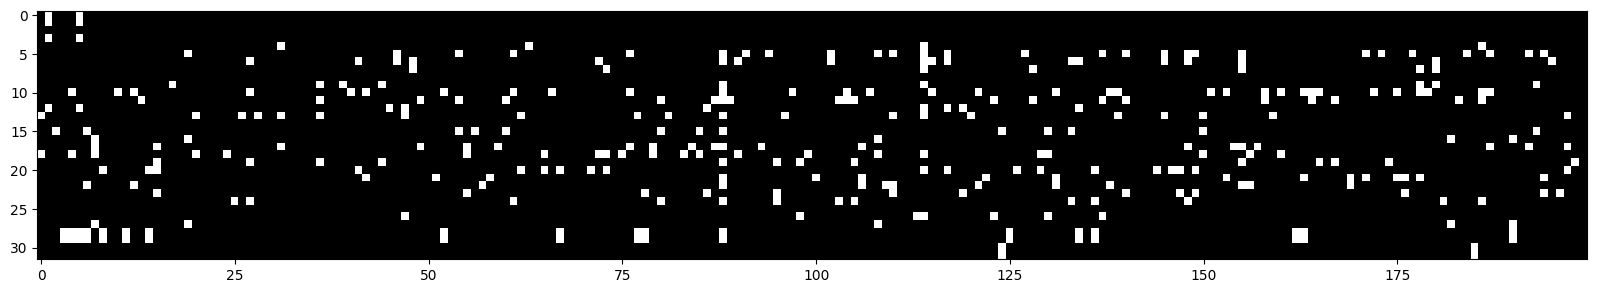

In [216]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([472., 228., 175., 186., 159., 122., 122., 126., 101.,  96.,  89.,
        103.,  99., 103.,  88.,  96.,  86., 118., 111., 111., 120.,  84.,
        111., 124.,  83.,  83.,  89., 123., 105.,  91.,  89.,  76.,  97.,
        120.,  99.,  89.,  85.,  77.,  96., 106.,  96., 115.,  87., 110.,
        115., 115., 157., 197., 244., 426.]),
 array([-9.99999404e-01, -9.60000397e-01, -9.20001390e-01, -8.80002383e-01,
        -8.40003376e-01, -8.00004369e-01, -7.60005362e-01, -7.20006355e-01,
        -6.80007348e-01, -6.40008341e-01, -6.00009334e-01, -5.60010327e-01,
        -5.20011320e-01, -4.80012313e-01, -4.40013306e-01, -4.00014299e-01,
        -3.60015292e-01, -3.20016285e-01, -2.80017278e-01, -2.40018271e-01,
        -2.00019264e-01, -1.60020257e-01, -1.20021250e-01, -8.00222433e-02,
        -4.00232363e-02, -2.42292881e-05,  3.99747777e-02,  7.99737847e-02,
         1.19972792e-01,  1.59971799e-01,  1.99970806e-01,  2.39969813e-01,
         2.79968820e-01,  3.19967827e-01,  3.59966

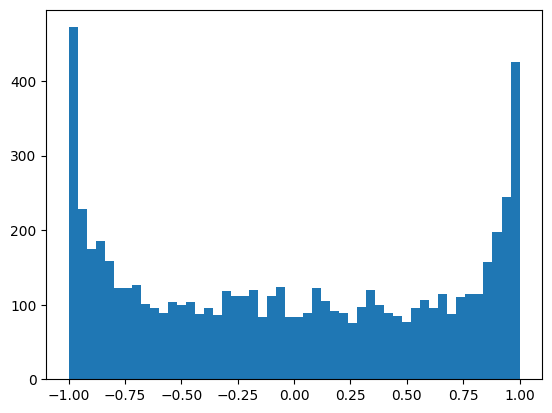

In [217]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   3.,   5.,
          7.,   8.,   8.,   8.,  21.,  31.,  37.,  63.,  67., 107., 146.,
        164., 215., 323., 348., 379., 504., 671., 640., 553., 425., 354.,
        270., 259., 202., 172., 112.,  76.,  80.,  48.,  42.,  16.,  12.,
          8.,   4.,   5.,   1.,   2.,   1.]),
 array([-7.51231098, -7.25590538, -6.99949978, -6.74309418, -6.48668858,
        -6.23028297, -5.97387737, -5.71747177, -5.46106617, -5.20466057,
        -4.94825497, -4.69184937, -4.43544376, -4.17903816, -3.92263256,
        -3.66622696, -3.40982136, -3.15341576, -2.89701015, -2.64060455,
        -2.38419895, -2.12779335, -1.87138775, -1.61498215, -1.35857655,
        -1.10217094, -0.84576534, -0.58935974, -0.33295414, -0.07654854,
         0.17985706,  0.43626266,  0.69266827,  0.94907387,  1.20547947,
         1.46188507,  1.71829067,  1.97469627,  2.23110188,  2.48750748,
         2.74391308,  3.00031868,  3.25672428,  3.51312988,  3.76953548,
 

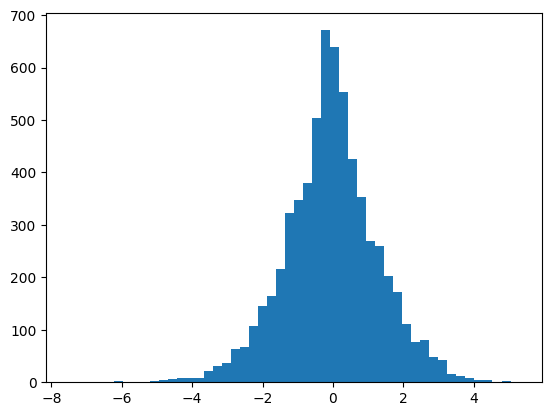

In [218]:
plt.hist(hreact.view(-1).tolist(), 50)

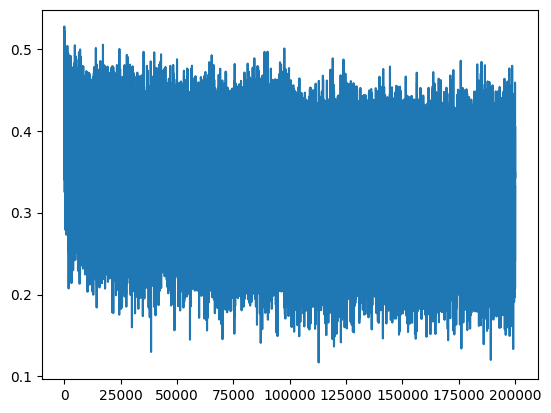

In [219]:
plt.plot(lossi)

In [220]:
with torch.no_grad(): 
    # Pass the training set through 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hreact = embcat @ W1 + b1
    bnmean = hreact.mean(0, keepdim=True)
    bnstd = hreact.std(0, keepdim=True)

In [221]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, blocksize, n_embd) 
    embcat = emb.view(emb.shape[0], -1 )  # Concatenate the vectors 
    hreact = embcat @ W1 + b1  # Hidden layer pre-activation 
    hreact = bngain *  (hreact - bnmean_running) / bnstd_running + bnbias # Normailization  
    h = torch.tanh( hreact )  # Hidden layer 
    logits = h @ W2 + b2  # Output layer 
    loss = F.cross_entropy(logits, y)  # loss function 
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.0643725395202637
val 2.1165218353271484


In [222]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)


for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True: 
        # forward pass the neural net 
        emb = C[torch.tensor([context])]  # (1, block_size, n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution 
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples 
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break  

print(''.join(itos[i] for i in out))  # decode and print the generated word 
    





jand.


In [ ]:
# loss log 
# original : overfitting  
#  train, eval 

# fix softmax confidently wrong 
# train, eval # almost the same value 

# fix tanh layer too saturated at init!
# train , eval 


In [215]:
#  SUMMARY ------------------------------

In [264]:
# Training deeper network 
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight  = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x ):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps 
        self.momentum = momentum 
        self.training = True 
        # parameters (training with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # Calculate the forward pass 
        if self.training:
            xmean = x.mean(0, keepdim=True)    # batch mean 
            xvar = x.var(0, keepdim=True)      # batch variance 
        else: 
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = ( x - xmean) / torch.sqrt(xvar + self.eps )  # normalize to unit variance 
        self.out = self.gamma * xhat + self.beta 
        
        # update the buffers
        if self.training:
            with torch.no_grad(): 
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_var = (1 -  self.momentum) * self.running_var + self.momentum * xvar 
        return self.out 
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
    def parameters(self):
        return []


n_embd = 10  # The dimensionality of the character embedding vectors 
n_hidden = 100 # The number of neurons in the hidden layer of the MLP 
g = torch.Generator().manual_seed(2147483647) # for reproducibility 

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]


with torch.no_grad():
    # last layer: make less confident 
    if isinstance(layers[-1], Linear):
        layers[-1].gamma *= 0.1 

    # all other layers: apply gain 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3



parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total 
for p in parameters:
    p.requires_grad = True 

47551


In [265]:
# Same optimization as last time 
max_steps = 200000
batch_size = 32
lossi = []
ud = []


for i in range(max_steps):
    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    

    # forward pass 
    emb = C[Xb] # embed the characters into vectors 
    x = emb.view(emb.shape[0], -1)  # Concatenate the vectors 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  
    

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # After_debug: would take out retain_graph 
    for p in parameters:
        p.grad = None 
    loss.backward()
    

    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay 
    for p in parameters:
        if p.grad is not None:  # Only update parameters with gradients
            p.data += -lr * p.grad

    
    # track stats 
    if i % 10000 == 0:  # print every once in a while 
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])  # comparing the  update to the data parameters 

    if i >= 1000:
        break   
print(loss.item())

      0/ 200000:3.7169
2.2575149536132812


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.25%
layer 5 (      Tanh): mean 0.00, std 0.64, saturated: 2.66%
layer 8 (      Tanh): mean 0.01, std 0.65, saturated: 2.03%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.94%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.53%


Text(0.5, 1.0, 'activation distribution')

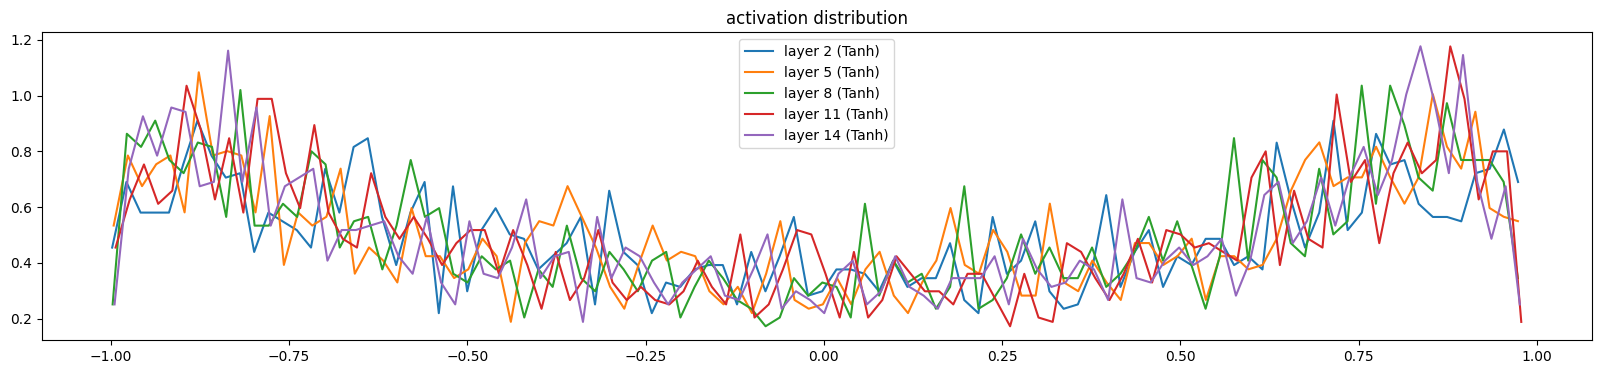

In [266]:
# visualize histograms 
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer 
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(),   ((t.abs() > 0.97).float().mean()*100)))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')


layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean 0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean 0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean 0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'Graditnent distribution')

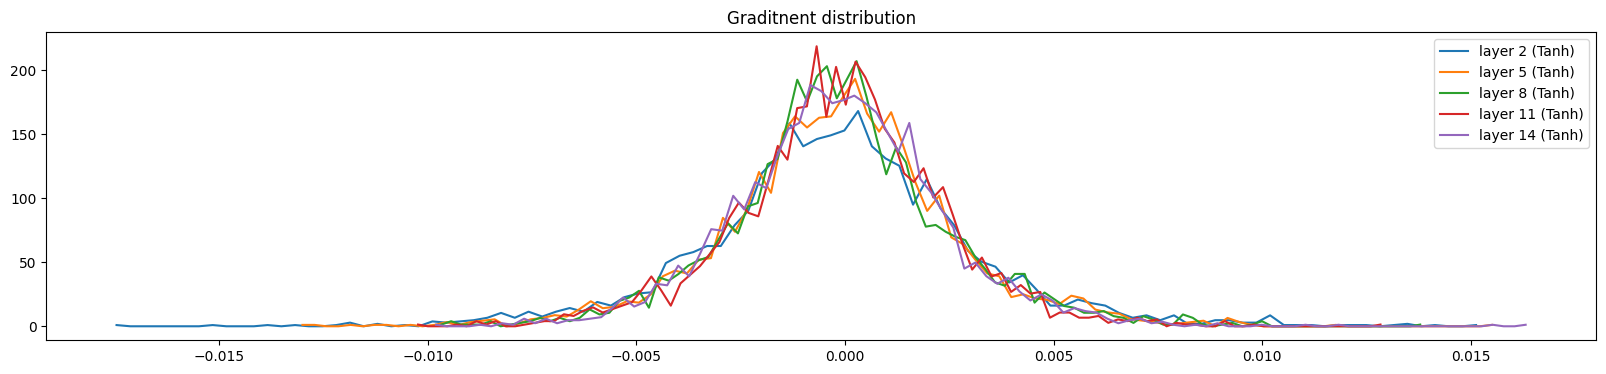

In [267]:
# visualize histograms 
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer 
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(),   ((t.abs() > 0.97).float().mean()*100)))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Graditnent distribution')


weight (  (27, 10)) | mean +0.000000 | std 7.664131e-03 | grad:data ratio 7.654483e-03
weight ( (30, 100)) | mean -0.000166 | std 6.892428e-03 | grad:data ratio 2.201519e-02
weight ((100, 100)) | mean -0.000005 | std 5.665629e-03 | grad:data ratio 3.375685e-02
weight ((100, 100)) | mean +0.000035 | std 4.900967e-03 | grad:data ratio 2.897888e-02
weight ((100, 100)) | mean +0.000051 | std 4.480151e-03 | grad:data ratio 2.663008e-02
weight ((100, 100)) | mean -0.000059 | std 4.237583e-03 | grad:data ratio 2.518304e-02
weight ( (100, 27)) | mean +0.000138 | std 8.650473e-03 | grad:data ratio 5.131298e-02


Text(0.5, 1.0, 'Weight Gradient distribution')

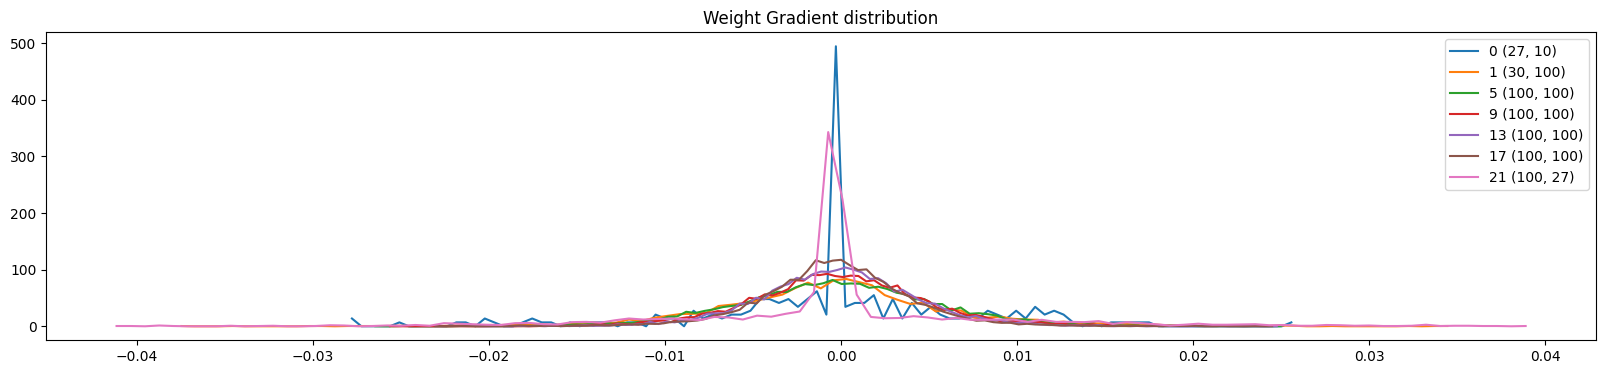

In [268]:
# visualize histograms 
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = []
for i, p in enumerate(parameters): # note: exclude the output layer 
    t = p.grad 
    if p.ndim == 2:
        print('weight (%10s) | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(),  t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weight Gradient distribution')


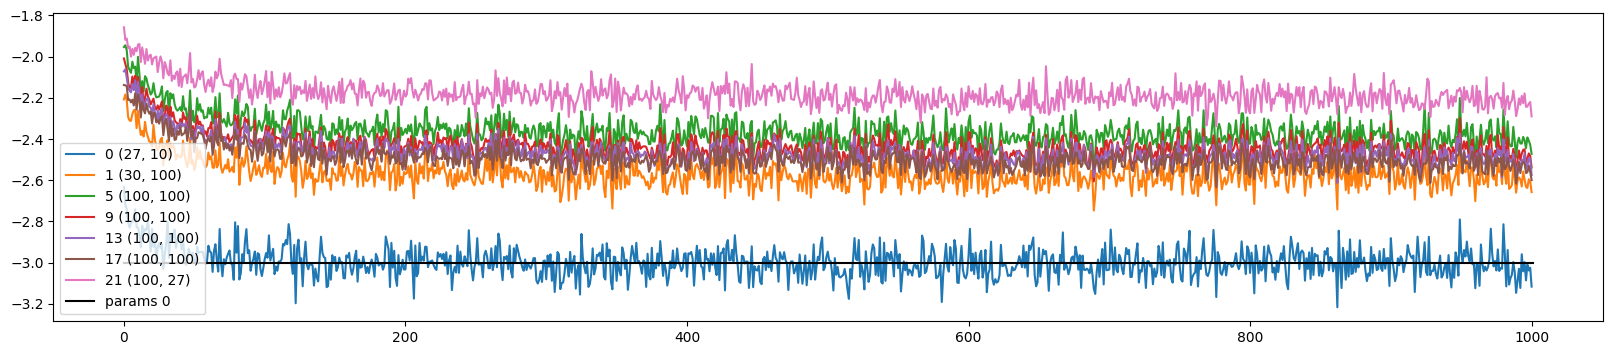

In [269]:
plt.figure(figsize=(20, 4))
legens = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('params %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # These ratios should be ~1e-3 indicate on plot 
plt.legend(legends)